#Description:
In this notebook, we will explore LSTM models' accuracy in one-step-ahead (daily) weather forecast

#Part 1: Data Preparation

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

place = 'Tallin-Harku'

C:\Users\krist\AppData\Local\Temp\ipykernel_15148\1721988922.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
#Reading data 
weather = pd.read_csv("Tallinn-Harku-2004-2023.csv", on_bad_lines='skip')
weather = weather[['Aasta','Kuu','Päev','Kell (UTC)','Tunni keskmine summaarne kiirgus W/m²','Õhurõhk merepinna kõrgusel hPa','Õhurõhk jaama kõrgusel hPa','Tunni sademete summa mm','Suhteline õhuniiskus %','Õhutemperatuur °C','Tunni miinimum õhutemperatuur °C','Tunni maksimum õhutemperatuur °C','10 minuti keskmine tuule suund °', '10 minuti keskmine tuule kiirus m/s', 'Tunni maksimum tuule kiirus m/s']]

# Combine 'Aasta', 'Kuu', 'Päev' and 'Kell (UTC)' into a datetime
weather['Date Time'] = pd.to_datetime(weather['Aasta'].astype(str) + weather['Kuu'].astype(str).str.zfill(2) + weather['Päev'].astype(str).str.zfill(2) + weather['Kell (UTC)'], format='%Y%m%d%H:%M')
date_time = weather['Date Time']
# Remove the 'Date Time' column
weather = weather.drop(['Aasta', 'Kuu', 'Päev', 'Kell (UTC)'], axis=1)

In [4]:
weather = weather.rename(columns={'Õhutemperatuur °C': 'temperature', 'Date Time': 'date', 'Tunni keskmine summaarne kiirgus W/m²' : 'radiation','Õhurõhk merepinna kõrgusel hPa' : 'pressure','Õhurõhk jaama kõrgusel hPa': 'pressure2','Tunni sademete summa mm' : 'precip','Suhteline õhuniiskus %' : 'humidity','Tunni miinimum õhutemperatuur °C' : 'tempmin','Tunni maksimum õhutemperatuur °C': 'tempmax','10 minuti keskmine tuule suund °' : 'winddir', '10 minuti keskmine tuule kiirus m/s' : 'windspeed', 'Tunni maksimum tuule kiirus m/s': 'windmax'})
weather['date'] = pd.to_datetime(weather['date'])
weather.set_index('date')
weather.head(5)

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,winddir,windspeed,windmax,date
0,0,1029.7,1025.4,0.2,99.0,-0.5,-0.4,-0.2,84.0,3.0,5.5,2008-01-01 00:00:00
1,0,1030.3,1026.1,0.2,99.0,-0.7,-0.8,-0.5,86.0,3.3,6.9,2008-01-01 01:00:00
2,0,1030.7,1026.5,0.2,99.0,-0.9,-0.9,-0.6,93.0,3.2,6.9,2008-01-01 02:00:00
3,0,1031.3,1027.0,0.0,98.0,-0.9,-1.0,-0.8,77.0,3.4,6.9,2008-01-01 03:00:00
4,0,1031.7,1027.5,0.0,97.0,-0.9,-0.9,-0.8,93.0,4.3,7.1,2008-01-01 04:00:00


Data description:

* date: YYYY-MM-DD

* temperature: average temperature in Istanbul at the given date, in degrees Celcius

* tempmax: maximum temperature in Istanbul at the given date, in degrees Celcius

* tempmin: minimum temperature in Istanbul at the given date, in degrees Celcius

* dew: dew point; required temperatuer to have dew in the air

* humidity: average humiditiy in Istanbul at the given date, as percentage

* precip: precipitation, in mm

* preciptype: type of precipitation, such as rain, snow

* windspeed: average windspeed in kilometers per hour

* winddir: direction of the wind, 360$^\circ$

* cloudcover: percentage of sky covered in cloud, daily average

Will be filling NA values of cloudcover with 0, NA values in precipitation type with None, and one-hot-encode precipitation type & month


There are only a few other NA values, deleting these rows will result negligible data loss.

In [5]:
weather.dropna(inplace=True)
weather.info

<bound method DataFrame.info of         radiation  pressure  pressure2  precip  humidity  temperature  \
0               0    1029.7     1025.4     0.2      99.0         -0.5   
1               0    1030.3     1026.1     0.2      99.0         -0.7   
2               0    1030.7     1026.5     0.2      99.0         -0.9   
3               0    1031.3     1027.0     0.0      98.0         -0.9   
4               0    1031.7     1027.5     0.0      97.0         -0.9   
...           ...       ...        ...     ...       ...          ...   
140251          0    1018.0     1013.7     0.0      84.0         -6.1   
140252          0    1018.3     1014.0     0.0      87.0         -6.9   
140253          0    1018.7     1014.4     0.0      88.0         -7.6   
140254          0    1018.7     1014.4     0.0      92.0         -8.2   
140255          0    1018.8     1014.4     0.0      90.0         -7.4   

        tempmin  tempmax  winddir  windspeed  windmax                date  
0          -0.4

In [6]:
weather['month'] = weather['date'].dt.month

In [7]:
weather.head(2)

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,winddir,windspeed,windmax,date,month
0,0,1029.7,1025.4,0.2,99.0,-0.5,-0.4,-0.2,84.0,3.0,5.5,2008-01-01 00:00:00,1
1,0,1030.3,1026.1,0.2,99.0,-0.7,-0.8,-0.5,86.0,3.3,6.9,2008-01-01 01:00:00,1


Our main dataframe will be "weather". Let's examine the data even more:

In [8]:
weather_seperated = weather[['date', 'month', 'temperature']].copy(deep=True)
weather_seperated['year'] = weather['date'].dt.year
weather_seperated.drop(['date'], axis=1, inplace=True)
weather_seperated = weather_seperated.pivot_table(index='month',  columns='year', values='temperature')
weather_seperated.head(2)

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
month,,,,,,,,,,,,,,,,
1,-0.460969,-1.973522,-11.003898,-3.537231,-4.736962,-4.414651,-6.641801,-0.885484,-7.179167,-1.801478,-1.692473,-4.124194,2.994489,-2.747312,-1.655108,-1.037231
2,1.319828,-4.233333,-7.612946,-9.604315,-7.978879,-2.355208,-0.055655,0.214583,0.544684,-2.285565,-6.431399,0.340476,1.533046,-5.154762,-0.337798,-0.964881


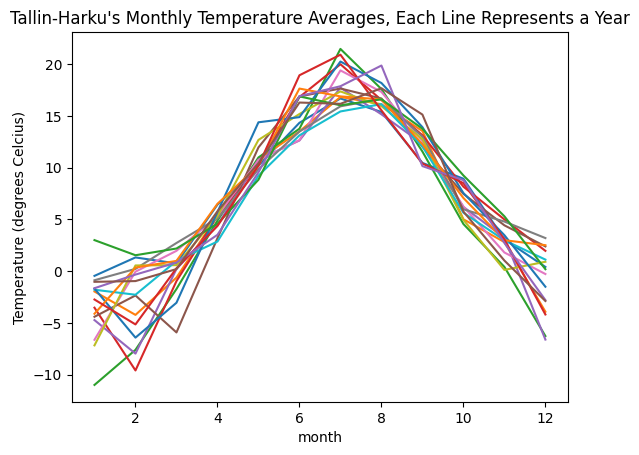

In [9]:
weather_seperated.plot()
plt.ylabel('Temperature (degrees Celcius)')
plt.title(f"{place}'s Monthly Temperature Averages, Each Line Represents a Year")
plt.legend().remove()
plt.show()

From the chart, we can see monthly temperature averages follow a meaningful seasonal trend.

Note: legend is removed as there are 32 years

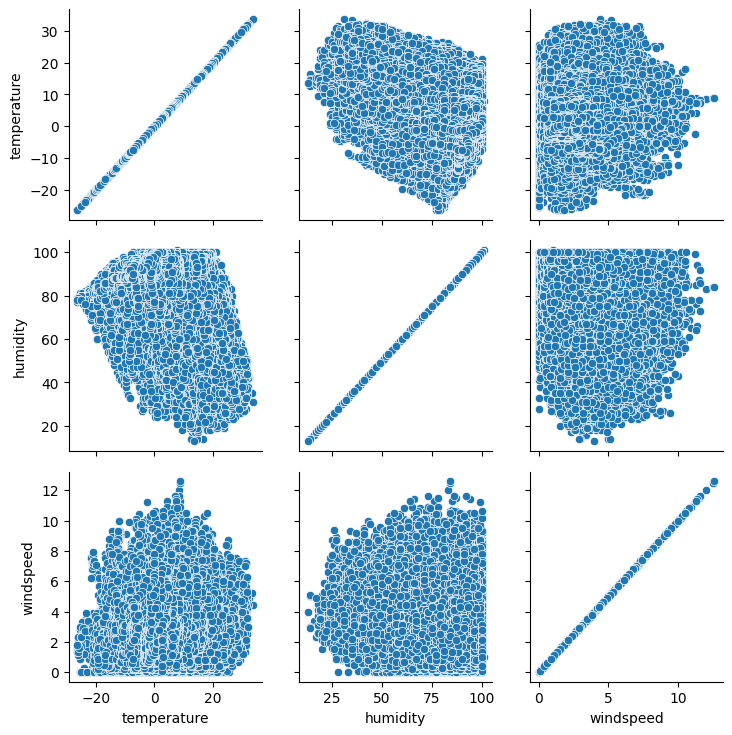

In [10]:
g = sns.PairGrid(weather[['temperature', 'humidity', 'windspeed']])
g.map(sns.scatterplot)

#Part 2: Checking the Naive prediction's error

A naive temperature prediction would be "tomorrow's average temperature will be the same with today". We will check the error term when we use this prediction and use it as the benchmark of our LSTM model.

In [11]:
weather_naive = weather[['date', 'temperature']].copy(deep=True)
weather_naive['prev_temperature'] = weather_naive['temperature'].shift(1)
weather_naive['difference'] = weather_naive['temperature'] - weather_naive['prev_temperature']
weather_naive['square_error'] = weather_naive['difference'] ** 2
weather_naive.head(2)

,date,temperature,prev_temperature,difference,square_error
0,2008-01-01 00:00:00,-0.5,NaN,NaN,NaN
1,2008-01-01 01:00:00,-0.7,-0.5,-0.2,0.04


In [12]:
square_error = weather_naive['square_error'].mean()
print(f'Square Error of the Naive Approach is {square_error:.3f}')

Square Error of the Naive Approach is 0.771


#Part 3: LSTM model for Weather Prediction

In [13]:
weather.head(2)

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,winddir,windspeed,windmax,date,month
0,0,1029.7,1025.4,0.2,99.0,-0.5,-0.4,-0.2,84.0,3.0,5.5,2008-01-01 00:00:00,1
1,0,1030.3,1026.1,0.2,99.0,-0.7,-0.8,-0.5,86.0,3.3,6.9,2008-01-01 01:00:00,1


In [14]:
#One-hot-encoding precipitation type and month
weather_LSTM = weather.copy(deep=True)
weather_LSTM.columns

Index(['radiation', 'pressure', 'pressure2', 'precip', 'humidity',
       'temperature', 'tempmin', 'tempmax', 'winddir', 'windspeed', 'windmax',
       'date', 'month'],
      dtype='object')

In [15]:
weather_LSTM.head(2)

,radiation,pressure,pressure2,precip,humidity,temperature,tempmin,tempmax,winddir,windspeed,windmax,date,month
0,0,1029.7,1025.4,0.2,99.0,-0.5,-0.4,-0.2,84.0,3.0,5.5,2008-01-01 00:00:00,1
1,0,1030.3,1026.1,0.2,99.0,-0.7,-0.8,-0.5,86.0,3.3,6.9,2008-01-01 01:00:00,1


In [16]:
input_data = weather_LSTM.drop(['date'], axis=1)
targets = weather_LSTM['temperature'].values

We need to decide how many days' prior we need to see to predict today. Trial and error is a valid approach, but for this example I will be using 20 days as the target is not to get the best answer, just to check if LSTM is getting better predictions than the naive approach.

In [17]:
T = 20             #Number of timesteps to look while predicting
D = input_data.shape[1]   #Dimensionality of the input
N = len(input_data) - T
print(f'Dimensions are {T} × {D} × {N}')

Dimensions are 20 × 12 × 140105


In [18]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

We need to create the train set and the test set and convert from numpy to torch.

In [19]:
# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

In [20]:
# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

In [21]:
# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

Using a classical LSTM structure

In [22]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    #batch_first to have (batch_dim, seq_dim, feature_dim)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    # initial hidden state and cell state
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    # h(T) at the final time step
    out = self.fc(out[:, -1, :])
    return out

For the number of hidden layers, the recommendation is 1 for simple problems and 2 for complex features. As our time series is slightly complex, I will be using 2.

Considering our training data size of 10,000 and input dimensionality; it's better to use hidden size at least 100 and at most 1000. 512 yielded good result.

In [23]:
model = LSTM(D, 512, 2, 1)
model.to(device)

LSTM(
  (rnn): LSTM(12, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

At training, Adam optimizer failed to converge for a long time (started to converge at around 800th epoch). SGD with 0.9 momentum worked well.

In [24]:
# Training
def train(model,
          learning_rate,
          X_train,
          y_train,
          X_test,
          y_test,
          epochs=200,
          batch_size=32):

  # Loss and optimizer
  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  train_data = torch.utils.data.TensorDataset(X_train, y_train)
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)

  for epoch in range(epochs):
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backpropagation
    loss.backward()
    optimizer.step()

    #Train loss
    train_losses[epoch] = loss.item()

    # Test loss
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[epoch] = test_loss.item()

    if (epoch + 1) % 50 == 0:
      print(f'At epoch {epoch+1} of {epochs}, Train Loss: {loss.item():.3f}, Test Loss: {test_loss.item():.3f}')

  return train_losses, test_losses

In [25]:
# move data to GPU
torch.cuda.empty_cache()
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [26]:
# Then you can call it with a batch size
batch_size = 8  # Reduce this if you're getting a CUDA out of memory error
train_losses, test_losses = train(model, 0.01, X_train, y_train, X_test, y_test, epochs=750, batch_size=batch_size)

OutOfMemoryError: CUDA out of memory. Tried to allocate 19.68 GiB. GPU 0 has a total capacity of 8.00 GiB of which 388.13 MiB is free. Of the allocated memory 6.23 GiB is allocated by PyTorch, and 7.17 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

We don't see an overfitting pattern. It's possible to train the model a little more as we haven't started to see the seperation of train loss - test loss in a meaningful manner, but the gains will be minimal.

In [ ]:
#Checking one-step prediction performance of the model
test_target = y_test.cpu().detach().numpy()
test_predictions = []

for i in range(len(test_target)):
  input_ = X_test[i].reshape(1, T, D)
  p = model(input_)[0,0].item()

  # update the predictions list
  test_predictions.append(p)


In [ ]:
plot_len = len(test_predictions)
plot_df = weather[['date', 'temperature']].copy(deep=True)
plot_df = plot_df.iloc[-plot_len:]
plot_df['prediction'] = test_predictions
plot_df.set_index('date', inplace=True)
plot_df.head(5)

,temperature,prediction
date,,
2016-08-27,24.4,23.652742
2016-08-28,24.5,24.186708
2016-08-29,24.7,24.835947
2016-08-30,24.5,25.238035
2016-08-31,24.7,25.056290


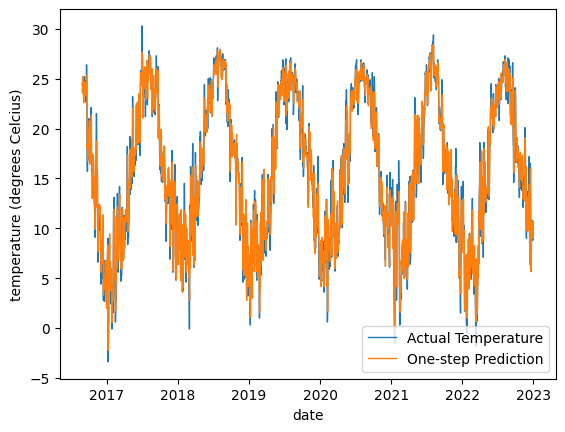

In [ ]:
plt.plot(plot_df['temperature'], label='Actual Temperature', linewidth=1)
plt.plot(plot_df['prediction'], label='One-step Prediction', linewidth=1)
plt.xlabel('date')
plt.ylabel('temperature (degrees Celcius)')
plt.legend(loc='lower right')

We are seeing a good fit. However, it seems the model is not good at predicting rapid increase/decrease in temperature in a short-period of time (a few days).

In [ ]:
LTSM_error = pd.DataFrame(test_target, columns = ['targets'])
LTSM_error['predictions'] =test_predictions
LTSM_error['error'] = LTSM_error['targets'] - LTSM_error['predictions']
LTSM_error['error_square'] = LTSM_error['error'] ** 2
err = LTSM_error['error_square'].mean()
print(f'Mean square error is: {err:.3f}')

Mean square error is: 2.558


Text(0.5, 1.0, 'Distribution of Differences')

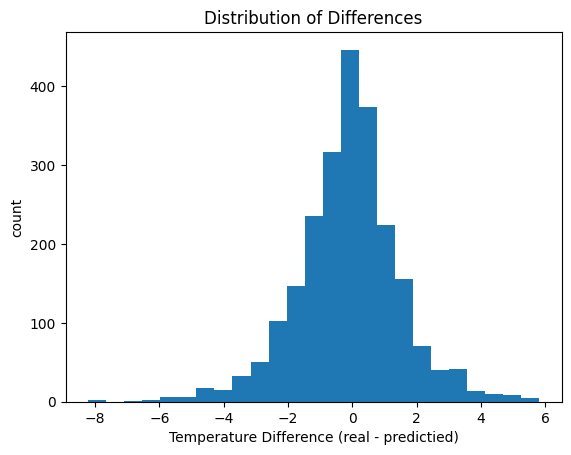

In [ ]:
plt.hist(LTSM_error['error'], bins=25)
plt.xlabel('Temperature Difference (real - predictied)')
plt.ylabel('count')
plt.title('Distribution of Differences')

#Discussion:

The LSTM model is better in predicting one-step-ahead average weather in degrees celcius, in compare to the naive model. The naive model's error was 3.54, LSTM reduced it to 2.56.

This model is not fine-tuned, so I believe further reduction in square error is possible. However, considering we only use data from Istanbul's previous weather (20-day) and weather prediction is complex, I believe it is not possible to reduce square error below 2.0.
